In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import os

In [2]:
nsims = 100
nside = 256
iband = 2
color = 'white'
flat = False
npix = hp.nside2npix(nside)
lmax = 3*nside-1
ls = np.arange(lmax+1)
pureE = True

In [3]:
mask = hp.ud_grade(hp.read_map("data/mask_apodized.fits"), nside_out=nside)
if flat:
    nhits = np.ones_like(mask)
else:
    nhits = hp.read_map(f"data/nhits_ns{nside}.fits.gz")

In [4]:
maskb = (mask > 0).astype(float)

In [5]:
b = nmt.NmtBin.from_nside_linear(nside, nlb=10)
f = nmt.NmtField(mask, None, spin=2, purify_b=True, purify_e=pureE)
w = nmt.NmtWorkspace.from_fields(f, f, b)
f_np = nmt.NmtField(mask, None, spin=2)
w_np = nmt.NmtWorkspace.from_fields(f_np, f_np, b)
leff = b.get_effective_ells()

In [6]:
os.system('mkdir -p data/cls')
cls = []
pcls = []
cls_np = []
pcls_np = []
for i in range(nsims):
    seed = 1000 + i
    if pureE:
        predir = 'data/cls'
    else:
        predir = 'data/cls/cls_nopureE'
    if flat:
        fname = f'{predir}/cls_noise_flat_{color}_band{iband}_{seed}.npz'
    else:
        fname = f'{predir}/cls_noise_{color}_band{iband}_{seed}.npz'
    if os.path.isfile(fname):
        d = np.load(fname)
        cl = d['cl']
        pcl = d['pcl']
        cl_np = d['cl_np']
        pcl_np = d['pcl_np']
    else:
        print(seed)
        if flat:
            q, u = hp.read_map(f'data/sims/sim_noise_flat_{color}_band{iband}_{seed}.fits.gz',
                               field=None)
        else:
            q, u = hp.read_map(f'data/sims/sim_noise_{color}_band{iband}_{seed}.fits.gz',
                               field=None)
        f = nmt.NmtField(mask, [q*maskb, u*maskb], purify_b=True, purify_e=pureE)
        pcl = nmt.compute_coupled_cell(f, f)
        cl = w.decouple_cell(pcl)
        f = nmt.NmtField(mask, [q*maskb, u*maskb])
        pcl_np = nmt.compute_coupled_cell(f, f)
        cl_np = w_np.decouple_cell(pcl)
        np.savez(fname, cl=cl, pcl=pcl, cl_np=cl_np, pcl_np=pcl_np)
    cls.append(cl)
    pcls.append(pcl)
    cls_np.append(cl_np)
    pcls_np.append(pcl_np)
cls = np.array(cls)
pcls = np.array(pcls)
cls_np = np.array(cls_np)
pcls_np = np.array(pcls_np)

In [7]:
sigma_map = np.zeros_like(mask)
good = nhits > 0
sigma_map[good] = 1/np.sqrt(nhits[good])
mask_noise = mask*sigma_map

In [8]:
def get_general_coupling_matrix(pcl_mask, s1, s2, n1, n2):
    lmax = len(pcl_mask)-1
    xi = nmt.nmtlib.comp_general_coupling_matrix(
        int(s1), int(s2), int(n1),
        int(n2), int(lmax),
        pcl_mask, int((lmax+1)**2))
    xi = xi.reshape([lmax+1, lmax+1])
    return xi

def get_beta(ll, s, inv=False):
    ls = np.atleast_1d(ll)
    beta = np.ones_like(ls)
    for n in range(1, 2*s+1):
        beta *= ls-s+n

    bad_ell = beta <= 0
    beta[bad_ell] = 1000
    beta = np.sqrt(beta)
    if not inv:
        beta = 1/beta
    beta[bad_ell] = 0

    if np.ndim(ll) == 0:
        beta = np.squeeze(beta)
    return beta

def spin_mask(mask, spin):
    mask_alm = hp.map2alm(mask)
    beta = get_beta(ls, spin, inv=True)
    mask_alm = -hp.almxfl(mask_alm, beta)
    return hp.alm2map_spin([mask_alm, 0*mask_alm], nside, spin, lmax)

def get_general_purified_mcm(mask, sigma):
    mask0 = mask
    mask1 = np.array(spin_mask(mask, 1))
    mask2 = np.array(spin_mask(mask, 2))
    elm_0 = -hp.map2alm(mask*sigma)
    blm_0 = 0*elm_0
    elm_1, blm_1 = hp.map2alm_spin(sigma*mask1, spin=1,
                                   lmax=lmax, mmax=lmax)
    elm_2, blm_2 = hp.map2alm_spin(sigma*mask2, spin=2,
                                   lmax=lmax, mmax=lmax)
    alms = np.array([[elm_0, blm_0],
                     [elm_1, blm_1],
                     [elm_2, blm_2]])
    cls_mask = np.array([[hp.alm2cl(e1, e2) + hp.alm2cl(b1, b2)
                          for e2, b2 in alms]
                         for e1, b1 in alms])
    mcms = np.array([[get_general_coupling_matrix(cls_mask[i1, i2],
                                                  2, 2, 2-i1, 2-i2)
                      for i1 in range(3)]
                     for i2 in range(3)])

    binoms = np.array([1., 2., 1.])
    beta_2 = get_beta(ls, 2)
    mcm = np.zeros([lmax+1, lmax+1])
    for n1 in range(3):
        ibeta_n1 = get_beta(ls, n1, inv=True)
        binom_n1 = binoms[n1]
        for n2 in range(3):
            ibeta_n2 = get_beta(ls, n2, inv=True)
            binom_n2 = binoms[n2]
            prefac = binom_n1 * binom_n2 * beta_2**2 * ibeta_n1 * ibeta_n2
            mcm += prefac[:, None]*mcms[2-n1, 2-n2]
    return mcm

def get_pnl_naive(mask, sigma, nl):
    rescale = np.mean((sigma*mask)**2)/np.mean(mask**2)
    b = nmt.NmtBin.from_nside_linear(nside, nlb=10)
    f = nmt.NmtField(mask, None, spin=2, purify_b=True, purify_e=pureE)
    w = nmt.NmtWorkspace.from_fields(f, f, b)
    pnl = w.couple_cell([nl, 0*nl, 0*nl, nl])*rescale
    return pnl

def get_pnl_white(mask, sigma, nl):
    mask_0 = mask
    mask_1 = np.sqrt(np.sum(np.array(spin_mask(mask, 1))**2, axis=0))
    mask_2 = np.sqrt(np.sum(np.array(spin_mask(mask, 2))**2, axis=0))
    avg_s2_w02 = np.mean((sigma*mask_0)**2)
    avg_s2_w12 = np.mean((sigma*mask_1)**2)
    avg_s2_w22 = np.mean((sigma*mask_2)**2)
    avg_w02 = np.mean(mask_0**2)
    beta_2 = get_beta(ls, 2)
    inv_beta_0 = get_beta(ls, 0, inv=True)
    inv_beta_1 = get_beta(ls, 1, inv=True)
    inv_beta_2 = get_beta(ls, 2, inv=True)
    rescale = avg_s2_w02/avg_w02
    shape_prediction = (1**2 * (beta_2 * inv_beta_0)**2 * avg_s2_w22/avg_s2_w02 +  # n=0
                        2**2 * (beta_2 * inv_beta_1)**2 * avg_s2_w12/avg_s2_w02 +  # n=0
                        1**2 * (beta_2 * inv_beta_2)**2 * avg_s2_w02/avg_s2_w02)
    pnl = nl*rescale*shape_prediction*avg_w02
    pnl = np.array([pnl, 0*pnl, 0*pnl, pnl])
    return pnl

def get_pnl(mask, sigma, nl):
    mcm = get_general_purified_mcm(mask, sigma)
    pnl = np.dot(mcm, nl)
    pnl = np.array([pnl, 0*pnl, 0*pnl, pnl])
    return pnl

In [9]:
def read_cls():
    d = np.load("data/nls.npz")
    ls = d['ls']
    if color == 'white':
        nl = d['nls_white'][iband]
    else:
        nl = d['nls'][iband]
    nl[:2] = 0
    return ls, nl


ls, nl = read_cls()

pcl_pred_naive = get_pnl_naive(mask, sigma_map, nl)
cl_pred_naive = w.decouple_cell(pcl_pred_naive)
pcl_pred_white = get_pnl_white(mask, sigma_map, nl)
cl_pred_white = w.decouple_cell(pcl_pred_white)
pcl_pred = get_pnl(mask, sigma_map, nl)
cl_pred = w.decouple_cell(pcl_pred)

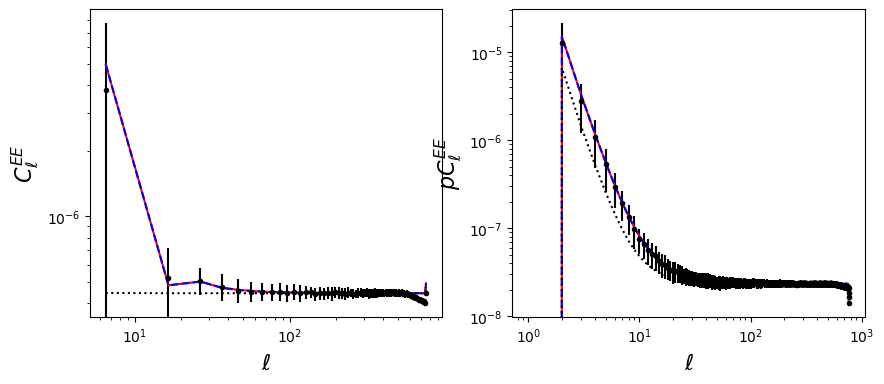

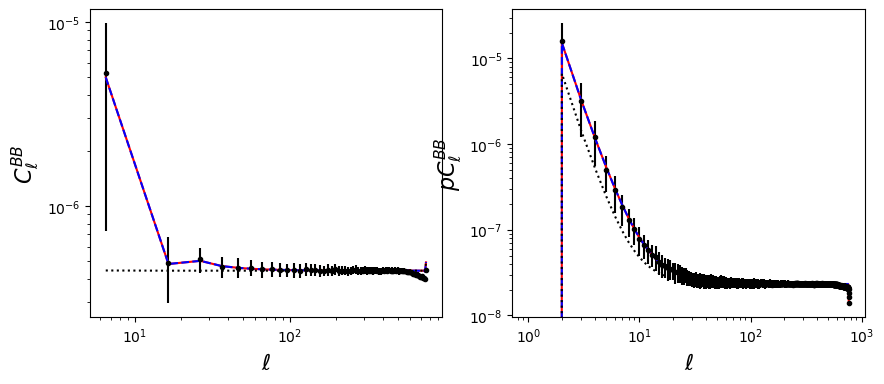

In [10]:
comb = ['EE', 'EB', 'BE', 'BB']
for icl in [0, 3]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Decoupled
    ax = axes[0]
    ax.errorbar(leff, np.mean(cls[:, icl, :], axis=0),
                 yerr=np.std(cls[:, icl, :], axis=0), fmt='k.')
    ax.plot(leff, cl_pred[icl], 'r-')
    ax.plot(leff, cl_pred_white[icl], 'b--')
    ax.plot(leff, cl_pred_naive[icl], 'k:')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$', fontsize=16)
    ax.set_ylabel(r'$C_\ell^{'+comb[icl]+'}$', fontsize=16)
    
    # Coupled
    ax = axes[1]
    ax.errorbar(ls, np.mean(pcls[:, icl, :], axis=0),
                 yerr=np.std(pcls[:, icl, :], axis=0), fmt='k.')
    ax.plot(ls, pcl_pred[icl], 'r-')
    ax.plot(ls, pcl_pred_white[icl], 'b--')
    ax.plot(ls, pcl_pred_naive[icl], 'k:')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$', fontsize=16)
    ax.set_ylabel(r'$pC_\ell^{'+comb[icl]+'}$', fontsize=16)

In [11]:
rescale = np.mean((sigma_map*mask)**2)/np.mean(mask**2)
n_ell = len(leff)
f = nmt.NmtField(mask, None, spin=2, purify_b=True, purify_e=pureE)
ww = nmt.NmtWorkspace.from_fields(f, f, b)
fn = nmt.NmtField(mask_noise/np.sqrt(rescale), None, spin=2)
cls_4cov = pcl_pred/np.mean(mask**2)
#cls_4cov = pcl_pred_white/np.mean(mask**2)
#cls_4cov = pcl_pred_naive/np.mean(mask**2)
#cls_4cov = np.mean(pcls, axis=0)/np.mean(mask**2)
cw = nmt.NmtCovarianceWorkspace.from_fields(fn, fn)

cov_sp2 = nmt.gaussian_covariance(cw, 2, 2, 2, 2,
                                  cls_4cov, cls_4cov,
                                  cls_4cov, cls_4cov,
                                  ww).reshape([n_ell, 4, n_ell, 4])

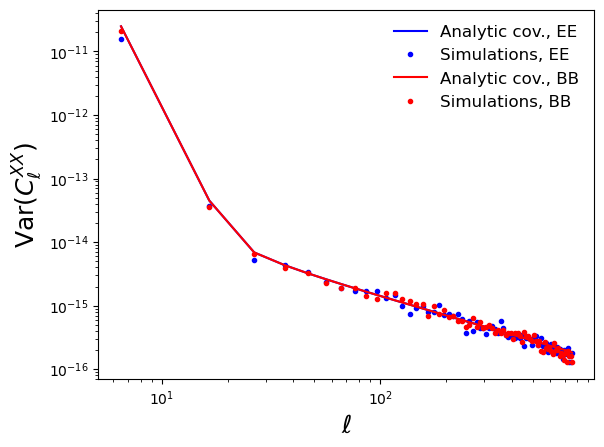

In [12]:
plt.figure()
plt.plot(leff, np.diag(cov_sp2[:, 0, :, 0]), 'b-', label='Analytic cov., EE')
plt.plot(leff, np.std(cls[:, 0, :], axis=0)**2, 'b.', label='Simulations, EE')
plt.plot(leff, np.diag(cov_sp2[:, 3, :, 3]), 'r-', label='Analytic cov., BB')
plt.plot(leff, np.std(cls[:, 3, :], axis=0)**2, 'r.', label='Simulations, BB')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=18)
plt.ylabel(r'${\rm Var}(C^{XX}_\ell)$', fontsize=18)
plt.legend(frameon=False, fontsize=12)